In [6]:
import numpy as np 
import pandas as pd 
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import datetime

from tqdm import tqdm

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers

import cv2 as cv

In [7]:
# Data path declaration

DATA_PATH = "input/"
MODELS_PATH = "models/"
LOGS_PATH = "logs/"
OUTPUT_PATH = "output/"

In [8]:
# Verification of directory paths 

if not os.path.isdir(MODELS_PATH):
    os.makedirs(MODELS_PATH)
if not os.path.isdir(LOGS_PATH):
    os.makedirs(LOGS_PATH)
if not os.path.isdir(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [9]:
# data loading

lab_df = pd.read_csv(DATA_PATH + "labels.csv")

In [10]:
display(lab_df.head(10))


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [11]:
lab_df.isnull().values.any() # checking for null  values if any

False

In [12]:
display(lab_df.describe())

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


<AxesSubplot:>

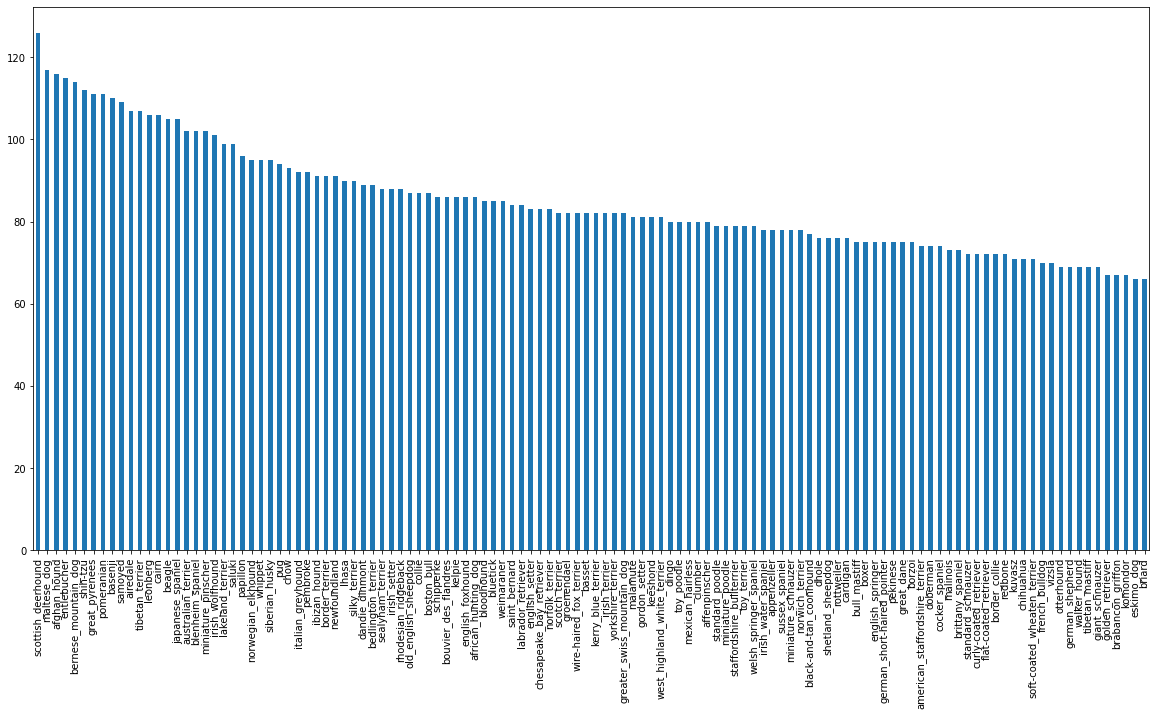

In [13]:
lab_df.breed.value_counts().plot.bar(figsize=(20, 10))

In [14]:
i = 0
img_height = []
img_width = []
img=[]

for f, breed in tqdm(lab_df.values):
    img = cv.imread(DATA_PATH + 'train/'+ '{}.jpg'.format(f))
    img_height.append(img.shape[0])
    img_width.append(img.shape[1])  

100%|██████████| 10222/10222 [01:05<00:00, 155.82it/s]


<AxesSubplot:xlabel='Width', ylabel='Count'>

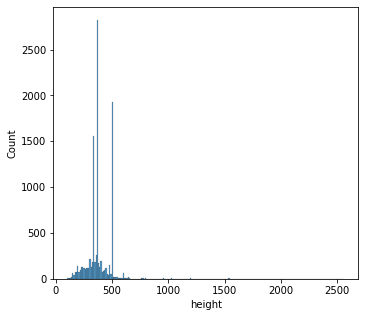

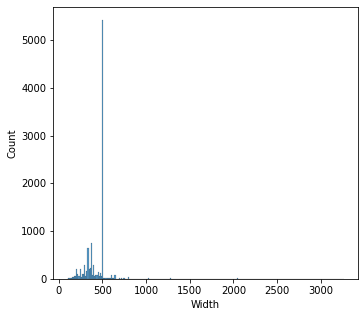

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.xlabel("height")
sns.histplot(img_height)

plt.figure(figsize=(12,5))
plt.subplot(122)
plt.xlabel("Width")
sns.histplot(img_width)

In [16]:
print("Width: Max {}, Mean {}, Median {}, Min {}".format(np.max(img_width),np.mean(img_width),np.median(img_width),np.min(img_width)))
print("Hight: Max {}, Mean {}, Median {}, Min {}".format(np.max(img_height),np.mean(img_height),np.median(img_height),np.min(img_height)))

Width: Max 3264, Mean 443.33153981608297, Median 500.0, Min 97
Hight: Max 2562, Mean 386.74721189591077, Median 375.0, Min 102


In [17]:
face_classifier = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")

# Single dog images

dog_img=[]
dog_classes=[]
D_img_height=[]
D_img_width=[]

# Image with noise 

multi_img=[]
multi_classes=[]
O_img_height=[]
O_img_width=[]

#load training images
for f, breed in tqdm(lab_df.values):
  imag = cv.imread(DATA_PATH + 'train/'+ '{}.jpg'.format(f))
  gray_image = cv.cvtColor(imag, cv.COLOR_BGR2GRAY)  
  face = face_classifier.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40))
  No_of_faces = len(face)
  if No_of_faces > 1:
    multi_classes.append(breed)
    multi_img.append(imag)
    O_img_height.append(imag.shape[0])
    O_img_width.append(imag.shape[1])
    O_img= imag
  else:
    dog_classes.append(breed)
    dog_img.append(imag)
    D_img_height.append(imag.shape[0])
    D_img_width.append(imag.shape[1])
    D_img= imag

100%|██████████| 10222/10222 [02:33<00:00, 66.79it/s]


(-0.5, 799.5, 603.5, -0.5)

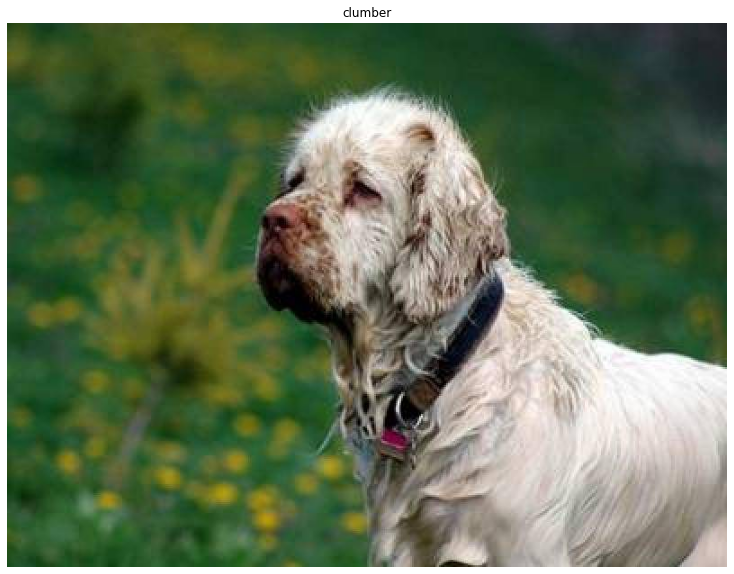

In [18]:
# Verifying dog image after filter

img_rgb = cv.cvtColor(dog_img[200], cv.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img_rgb)
plt.title(dog_classes[200])
plt.axis('off')

(-0.5, 388.5, 546.5, -0.5)

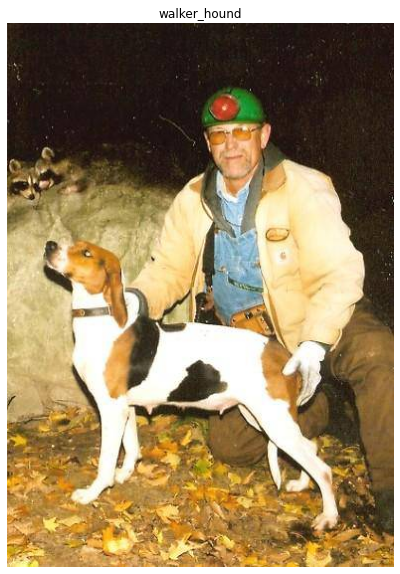

In [19]:
# Verifying mixed image after filter

img_rgb = cv.cvtColor(multi_img[250], cv.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img_rgb)
plt.title(multi_classes[250])
plt.axis('off')

<AxesSubplot:xlabel='Width {Dog data}', ylabel='Count'>

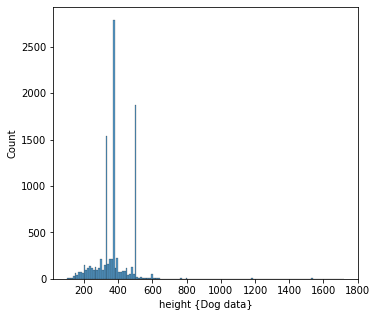

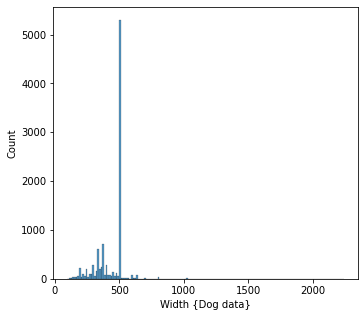

In [20]:
# Statestical insight on filtered dog image

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.xlabel("height {Dog data}")
sns.histplot(D_img_height)

plt.figure(figsize=(12,5))
plt.subplot(122)
plt.xlabel("Width {Dog data}")
sns.histplot(D_img_width)

<AxesSubplot:xlabel='Width {Other data}', ylabel='Count'>

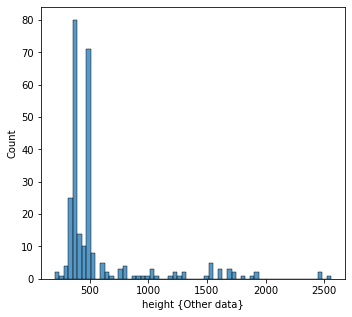

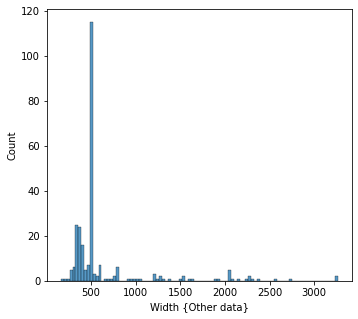

In [21]:
# Statestical insight on filtered mixed image

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.xlabel("height {Other data}")
sns.histplot(O_img_height)

plt.figure(figsize=(12,5))
plt.subplot(122)
plt.xlabel("Width {Other data}")
sns.histplot(O_img_width)

In [22]:
dfh = pd.DataFrame(D_img_height, columns = ['height'])

P25_h = dfh['height'].quantile(0.25)
P75_h = dfh['height'].quantile(0.75)
IQR_h = P75_h - P25_h

UL_h = P75_h + 1.5 * IQR_h
LL_h = P25_h - 1.5 * IQR_h

dfw= pd.DataFrame(D_img_width, columns = ['width'])

P25_w = dfw['width'].quantile(0.25)
P75_w = dfw['width'].quantile(0.75)
IQR_w = P75_w - P25_w

UL_w = P75_w + 1.5 * IQR_w
LL_w = P25_w - 1.5 * IQR_w

print("Height: 25 percetile limit {}, 75 percetile limit limit {}, IQR {}, Upper limit {}, Lower limit {}".format(P25_h, P75_h, IQR_h, UL_h, LL_h))
print("Width: 25 percetile limit {}, 75 percetile limit limit {}, IQR {}, Upper limit {}, Lower limit {}".format(P25_w, P75_w, IQR_w, UL_w, LL_w))

Height: 25 percetile limit 333.0, 75 percetile limit limit 448.0, IQR 115.0, Upper limit 620.5, Lower limit 160.5
Width: 25 percetile limit 360.0, 75 percetile limit limit 500.0, IQR 140.0, Upper limit 710.0, Lower limit 150.0


In [23]:
# Omition of outliers from analysis

dog_img_F=[]
dog_classes_F=[]
D_img_height_F=[]
D_img_width_F=[]

for i in tqdm(D_img_height):
  if ((D_img_height[i]<=UL_h) and (D_img_height[i]>=LL_h) and (D_img_width[i]<=UL_w) and (D_img_width[i]>=LL_w)):
    dog_img_F.append(dog_img[i])
    dog_classes_F.append(dog_classes[i])
    D_img_height_F.append(D_img_height[i])
    D_img_width_F.append(D_img_width[i])

100%|██████████| 9957/9957 [00:00<00:00, 795676.74it/s]


<AxesSubplot:xlabel='Width', ylabel='Count'>

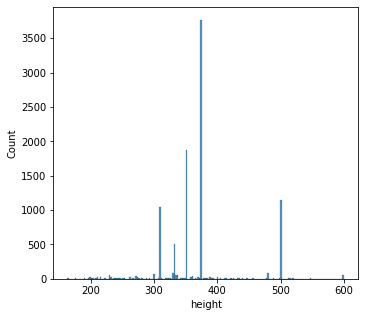

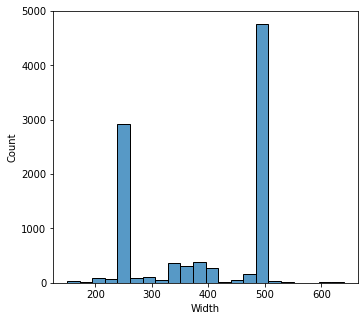

In [24]:
# Statestical insight after omition of outliers

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.xlabel("height")
sns.histplot(D_img_height_F)

plt.figure(figsize=(12,5))
plt.subplot(122)
plt.xlabel("Width")
sns.histplot(D_img_width_F)

In [25]:
import random
random_index = random.sample(range(0,len(dog_classes_F)), 1000)
print(random_index)

[6760, 6795, 118, 4666, 4075, 8856, 2069, 2464, 9021, 7000, 195, 8519, 1161, 1655, 508, 5308, 9112, 5173, 9723, 4625, 8877, 2420, 7330, 4691, 4727, 7445, 3921, 6060, 3002, 2623, 8050, 4456, 5549, 7799, 5610, 7663, 4981, 7689, 853, 5828, 6712, 2024, 596, 6865, 8079, 6861, 6200, 6430, 4185, 5616, 7266, 3271, 6879, 2153, 383, 7841, 4686, 9624, 2705, 7296, 8280, 4736, 1529, 6207, 4441, 318, 84, 965, 1952, 6058, 9555, 448, 1184, 616, 1017, 1306, 2480, 3894, 9040, 3485, 8927, 3421, 6698, 6606, 4043, 2841, 6827, 4824, 9591, 5357, 4608, 5937, 4968, 2767, 6127, 6876, 2949, 1756, 5115, 6990, 3957, 8709, 1911, 7015, 7056, 4902, 7477, 1372, 9460, 6508, 278, 3976, 1697, 7218, 3057, 2802, 9427, 2487, 2057, 6346, 2929, 2728, 5419, 7145, 6467, 7887, 7892, 6037, 705, 2639, 8697, 817, 4432, 6676, 4507, 926, 5761, 9362, 8329, 1698, 1204, 4489, 9405, 932, 8121, 1253, 2380, 5753, 1612, 4906, 4187, 1466, 7327, 6781, 8111, 1887, 5801, 5363, 6659, 4685, 4235, 7832, 612, 194, 2442, 4318, 3866, 264, 3857, 2221,

In [26]:
dog_img_sample=[]
dog_classes_sample=[]

for i in tqdm(range(1000)):
  j=random_index[i]
  dog_img_sample.append(dog_img_F[j])
  dog_classes_sample.append(dog_classes_F[j])

100%|██████████| 1000/1000 [00:00<00:00, 1998239.16it/s]


In [27]:
# Image preprocessing routine

def image_preprocessing(image, W, H):

    # Load Image
    readFlag=cv.COLOR_BGR2GRAY
    image_gray = cv.cvtColor(image, readFlag)
    
    # Crop Image
    mid_row = int(image_gray.shape[0]/2)
    mid_col = int(image_gray.shape[1]/2)
    if image_gray.shape[0]>image_gray.shape[1]:
        image_cropped = image_gray[mid_row-mid_col:mid_row+mid_col,
                                   0:image_gray.shape[1]]
    else:
        image_cropped = image_gray[0:image_gray.shape[0],
                                   mid_col-mid_row:mid_col+mid_row]
    
    # Rescale Image
    image_rescale = cv.resize(image_cropped,
                               dsize=(W, H),
                               interpolation=cv.INTER_AREA)
    return image_rescale

In [28]:
X = np.empty((len(dog_classes_sample), 224, 224), dtype=np.uint8)

for i in tqdm(range(1000)):
  image_rescaled = image_preprocessing(dog_img_sample[i], 224, 224) # due to computation limitation, need to drop image size to 224 * 224
  X[i, :, :] = image_rescaled

X = X.astype('float32')/255

100%|██████████| 1000/1000 [00:00<00:00, 2551.98it/s]


In [29]:
Y = pd.get_dummies(dog_classes_sample)
X = X.reshape(-1,224,224,1)

In [30]:
print('\nTrain Images shape: ',X.shape,' size: {:,}'.format(X.size))
print('One-hot encoded output shape: ',Y.shape,' size: {:,}'.format(Y.size))


Train Images shape:  (1000, 224, 224, 1)  size: 50,176,000
One-hot encoded output shape:  (1000, 100)  size: 100,000


In [31]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

print('Shape X train data:', X_train.shape)
print('Shape Y train data:', Y_train.shape)
print('Shape X val data:', X_val.shape)
print('Shape Y val data:', Y_val.shape) 

Shape X train data: (800, 224, 224, 1)
Shape Y train data: (800, 100)
Shape X val data: (200, 224, 224, 1)
Shape Y val data: (200, 100)


In [32]:
%load_ext tensorboard

In [33]:
# Function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join(LOGS_PATH, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    # make it so the logs get tracked whenever we run an experiment
    return tf.keras.callbacks.TensorBoard(logdir)

In [34]:
# Create Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)

In [35]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2))) #3 , 3

model.add(Conv2D(filters = 16, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2))) # 7,7

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(Y_train.shape[1], activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.001),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      51232     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 16)        12816     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0

In [36]:
# Create a new TensorBoard session everytime we train a model
tensorboard = create_tensorboard_callback()

# Training the model
epochs = 25
batch_size = 50

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val),callbacks=[tensorboard, early_stopping])

Epoch 1/25
16/16 [==============================] - 15s 88ms/step - loss: 6.4821 - accuracy: 0.4150 - val_loss: 5.1158 - val_accuracy: 0.6200
Epoch 2/25
16/16 [==============================] - 1s 76ms/step - loss: 4.3701 - accuracy: 0.5938 - val_loss: 3.7658 - val_accuracy: 0.6350
Epoch 3/25
16/16 [==============================] - 1s 77ms/step - loss: 3.4666 - accuracy: 0.6538 - val_loss: 3.2440 - val_accuracy: 0.6750
Epoch 4/25
16/16 [==============================] - 1s 77ms/step - loss: 2.9877 - accuracy: 0.6625 - val_loss: 2.9027 - val_accuracy: 0.6750
Epoch 5/25
16/16 [==============================] - 1s 77ms/step - loss: 2.5398 - accuracy: 0.7175 - val_loss: 2.7050 - val_accuracy: 0.7000
Epoch 6/25
16/16 [==============================] - 1s 78ms/step - loss: 2.1347 - accuracy: 0.7862 - val_loss: 2.6044 - val_accuracy: 0.7600
Epoch 7/25
16/16 [==============================] - 1s 76ms/step - loss: 1.8169 - accuracy: 0.8400 - val_loss: 2.5273 - val_accuracy: 0.7950
Epoch 8/25
1

In [37]:
%tensorboard --logdir LOGS_PATH

In [38]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_accuracy = model.history.history['accuracy']
validation_accuracy = model.history.history['val_accuracy']

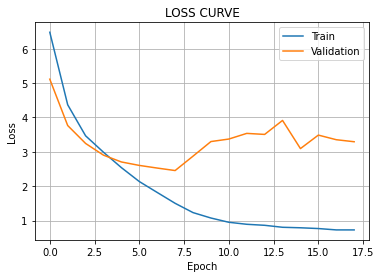

In [39]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LOSS CURVE")
plt.legend(['Train', 'Validation'])
plt.grid()
plt.show()

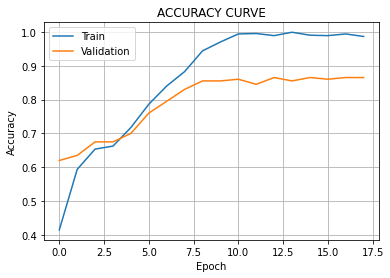

In [40]:
plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ACCURACY CURVE")
plt.legend(['Train', 'Validation'])
plt.grid()
plt.show()

In [41]:
random_test_index = random.sample(range(0,len(dog_classes_F)), 1000)
print(random_test_index)

[1977, 1964, 1216, 4727, 5019, 8647, 5247, 6177, 3729, 3448, 9691, 5974, 2922, 7536, 667, 8708, 5660, 5946, 2620, 9581, 9344, 4857, 9129, 2915, 1314, 7551, 7354, 8353, 9307, 6071, 3769, 2161, 1019, 3159, 4487, 2604, 3230, 8210, 510, 3506, 7643, 3224, 9325, 9103, 7070, 705, 8850, 6868, 5291, 697, 3926, 2603, 2415, 2149, 6205, 1067, 3147, 3534, 9140, 4034, 1767, 359, 6743, 6875, 1807, 7525, 4375, 5979, 6430, 9328, 520, 6060, 5372, 4237, 222, 8767, 5545, 8470, 3402, 1695, 6492, 5913, 4090, 3455, 1300, 4465, 1039, 3543, 3691, 7744, 3461, 4087, 5815, 3746, 6288, 1934, 9489, 8866, 8285, 8130, 8034, 3633, 4430, 1889, 4165, 1145, 5127, 9576, 4735, 7392, 1869, 315, 6460, 8099, 7917, 3893, 8548, 5066, 6525, 9476, 7180, 5197, 9049, 4928, 8295, 6847, 2366, 3875, 473, 5130, 2612, 7253, 2019, 395, 8831, 779, 5167, 258, 3541, 4415, 5732, 9067, 3081, 2191, 4546, 9324, 5954, 2167, 5953, 9728, 895, 7941, 1428, 490, 5017, 1084, 3969, 6170, 7227, 2468, 2585, 165, 1066, 6378, 2073, 7714, 4626, 572, 4278, 6

In [42]:
dog_img_test_sample=[]
dog_classes_test_sample=[]

for i in tqdm(range(1000)):
  j=random_test_index[i]
  dog_img_test_sample.append(dog_img_F[j])
  dog_classes_test_sample.append(dog_classes_F[j])

100%|██████████| 1000/1000 [00:00<00:00, 999357.64it/s]


In [43]:
X_test = np.empty((len(dog_classes_test_sample), 224, 224), dtype=np.uint8)

for i in tqdm(range(1000)):
  image_rescaled = image_preprocessing(dog_img_test_sample[i], 224, 224) # due to computation limitation, need to drop image size to 224 * 224
  X_test[i, :, :] = image_rescaled

X_test = X_test.astype('float32')/255

100%|██████████| 1000/1000 [00:00<00:00, 2580.82it/s]


In [44]:
Y_test = pd.get_dummies(dog_classes_test_sample)
X_test = X_test.reshape(-1,224,224,1)

In [45]:
print('\nTest Images shape: ',X_test.shape,' size: {:,}'.format(X_test.size))
print('One-hot encoded output shape: ',Y_test.shape,' size: {:,}'.format(Y_test.size))


Test Images shape:  (1000, 224, 224, 1)  size: 50,176,000
One-hot encoded output shape:  (1000, 100)  size: 100,000


In [46]:
# Predisction for 1000 random test samples

predictions = model.predict(X_test, verbose=1)
predictions

32/32 [==============================] - 1s 18ms/step


array([[2.79720176e-13, 1.90510389e-06, 1.53957370e-12, ...,
        2.02458750e-13, 5.36888107e-14, 9.99989271e-01],
       [2.18692196e-27, 1.06271249e-24, 5.17622919e-31, ...,
        1.49995432e-28, 9.45648515e-29, 1.01447574e-26],
       [8.67843653e-18, 5.62105887e-16, 5.58174934e-21, ...,
        2.61257552e-19, 4.17431171e-26, 1.76164094e-23],
       ...,
       [1.29910367e-08, 2.88585933e-10, 3.41019476e-13, ...,
        4.81191233e-11, 6.56807464e-12, 1.05160517e-15],
       [2.79398710e-13, 1.90745118e-06, 1.53630906e-12, ...,
        2.02598219e-13, 5.40238969e-14, 9.99989390e-01],
       [5.78377047e-04, 6.97442710e-01, 3.99773944e-06, ...,
        2.04931325e-06, 3.19909759e-06, 6.64136662e-11]], dtype=float32)

In [47]:
def image_predict(index):
    
    # Result visualisation for individual sample
    
    Prob_mat = predictions[index] 
    Pred_label = Y_train.columns[np.argmax(predictions[index])]
    True_label = dog_classes_test_sample[index]

    # Find the top 5 prediction confidence indexes
    Top_5_pred_indexes = Prob_mat.argsort()[-5:][::-1]

    # Find the prediction connfidence values of top 5
    Top_5_pred_values = Prob_mat[Top_5_pred_indexes]

    # Find the prediction labels of top 5
    Top_5_pred_labels = Y_train.columns[Top_5_pred_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(Top_5_pred_labels)),Top_5_pred_values, color="grey")

    plt.xticks(np.arange(len(Top_5_pred_labels)),labels=Top_5_pred_labels, rotation="vertical")

    # Change color of true label
    if np.isin(True_label, Top_5_pred_labels):
      top_plot[np.argmax(Top_5_pred_labels == True_label)].set_color("green")
    

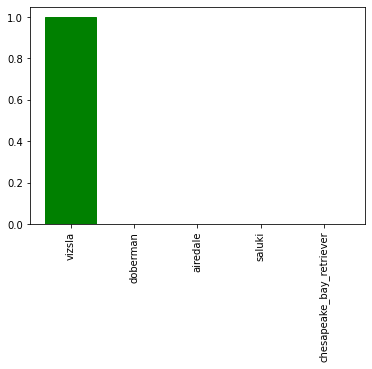

In [48]:
image_predict(52)

In [49]:
Val_Pred_label = []
Val_True_label = []

for i in tqdm(range(1000)): 
    Val_Pred_label.append(Y_train.columns[np.argmax(predictions[i])])
    Val_True_label.append(dog_classes_test_sample[i])

100%|██████████| 1000/1000 [00:00<00:00, 222014.82it/s]


In [50]:
df_result = pd.DataFrame()
df_result['Val_True'] = Val_True_label
df_result['Val_Pred'] = Val_True_label

In [51]:
df_result

,Val_True,Val_Pred
0,wire-haired_fox_terrier,wire-haired_fox_terrier
1,miniature_pinscher,miniature_pinscher
2,vizsla,vizsla
3,basset,basset
4,miniature_pinscher,miniature_pinscher
...,...,...
995,groenendael,groenendael
996,english_springer,english_springer
997,newfoundland,newfoundland
998,wire-haired_fox_terrier,wire-haired_fox_terrier


In [57]:
df_result.to_csv("output/output.csv")